In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.priors import GammaPrior
from edbo.bro import BO
from adjustText import adjust_text

%matplotlib inline

In [2]:
from data_loader import suzuki, load_CASP15

test_casp15 = load_CASP15()

print("CASP15 Dataset: ")
print(test_casp15)

CASP15 Dataset: 
      AL0_P  TM-score  TM-align  AL4_P    QCS  Z-score  Handed.     SS   DFM  \
0     77.78     0.794     0.797  88.89  87.09     7.43     0.91  0.463  0.17   
1     36.47     0.410     0.444  41.76  53.52     2.81     0.91  0.520  0.37   
2     72.17     0.888     0.893  87.39  97.86    12.90     0.94  0.650  0.09   
3     95.50     0.921     0.924  98.20  97.10     8.25     0.95  0.678  0.04   
4     57.27     0.571     0.569  64.55  67.85     3.86     0.92  0.462  0.22   
...     ...       ...       ...    ...    ...      ...      ...    ...   ...   
3999  95.50     0.929     0.932  98.20  97.33     8.25     0.95  0.694  0.04   
4000  95.93     0.972     0.972  96.83  99.00    10.91     0.97  0.780  0.05   
4001  95.50     0.943     0.946  98.20  97.77     8.25     0.96  0.698  0.04   
4002   0.00     0.388     0.405   0.00  26.25     0.84     0.80  0.204  0.32   
4003  88.33     0.733     0.733  98.33  79.79     5.93     0.90  0.429  0.06   

      GDT_TS  
0      

### Data Preprocessing

In [6]:
from edbo.utils import Data
from data_loader import suzuki, load_CASP15

#casp15 = Data(casp15()) # load casp data
casp15 = Data(load_CASP15()) # .sample(frac=0.5).reset_index(drop=True))

# drop any unwanted columns 
# casp15.drop(['AL0_P','QCS','Z-score','TM-align','SS','DFM','Handed.','AL4_P','TM-score']) 
# casp15.drop(['TM-align','SS','DFM','Handed.','TM-score'])
casp15.drop(['AL0_P','QCS','Z-score','TM-align','SS','Handed.']) 
#casp15.drop(['Handed.'])
# remaining variables: [TM-score]

# Standardize (normalize, etc)
casp15.standardize(target='GDT_TS')

# Drop highly correlated features
#casp15.uncorrelated(target='GDT_TS', threshold=0.75)

print(casp15.data)

      TM-score  AL4_P   DFM  GDT_TS
0        0.794  88.89  0.17   76.92
1        0.410  41.76  0.37   38.38
2        0.888  87.39  0.09   70.54
3        0.921  98.20  0.04   91.89
4        0.571  64.55  0.22   55.45
...        ...    ...   ...     ...
3999     0.929  98.20  0.04   92.57
4000     0.972  96.83  0.05   96.49
4001     0.943  98.20  0.04   95.05
4002     0.388   0.00  0.32   48.33
4003     0.733  98.33  0.06   82.08

[4004 rows x 4 columns]


#### Visualise the dataset

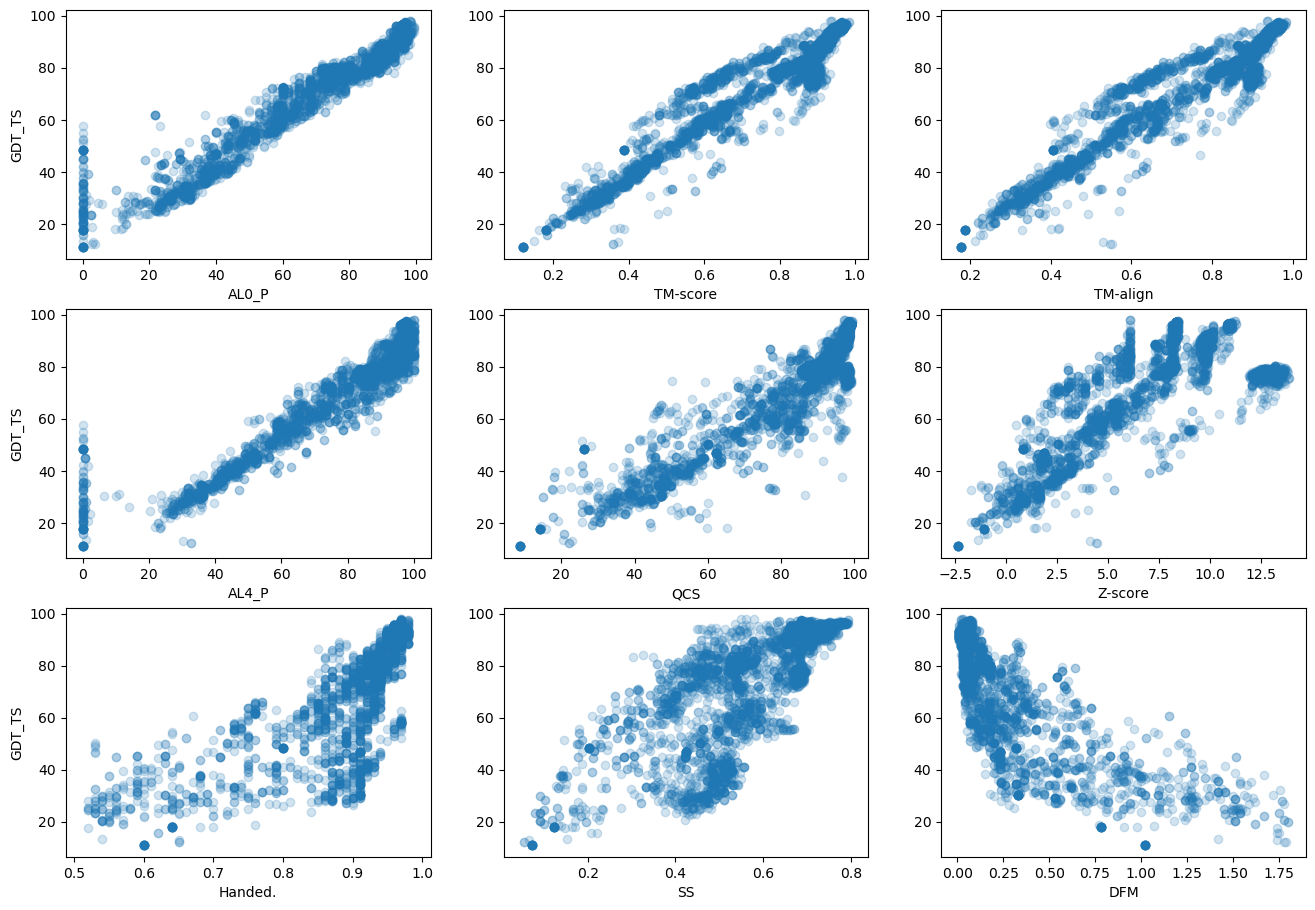

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from edbo.math_utils import pca

# extract the column names from the dataset
cols = casp15.data.columns

# output - GDT_TS column
y = casp15.data['GDT_TS']

# creating the plot
#pca_plot = ax.scatter3D(xx, yy, zz, c=zz, cmap='viridis');
fig = plt.figure(figsize=(16,11))
#fig.suptitle('CASP15 Dataset', fontsize=20)
axarr = fig.subplots(3,3)

axarr[0][0].scatter(casp15.data[cols[0]], y, alpha=0.2), axarr[0][0].set(xlabel=cols[0], ylabel='GDT_TS')
axarr[0][1].scatter(casp15.data[cols[1]], y, alpha=0.2), axarr[0][1].set(xlabel=cols[1])
axarr[0][2].scatter(casp15.data[cols[2]], y, alpha=0.2), axarr[0][2].set(xlabel=cols[2])
axarr[1][0].scatter(casp15.data[cols[3]], y, alpha=0.2), axarr[1][0].set(xlabel=cols[3], ylabel='GDT_TS')
axarr[1][1].scatter(casp15.data[cols[4]], y, alpha=0.2), axarr[1][1].set(xlabel=cols[4])
axarr[1][2].scatter(casp15.data[cols[5]], y, alpha=0.2), axarr[1][2].set(xlabel=cols[5])
axarr[2][0].scatter(casp15.data[cols[6]], y, alpha=0.2), axarr[2][0].set(xlabel=cols[6], ylabel='GDT_TS')
axarr[2][1].scatter(casp15.data[cols[7]], y, alpha=0.2), axarr[2][1].set(xlabel=cols[7])
axarr[2][2].scatter(casp15.data[cols[8]], y, alpha=0.2), axarr[2][2].set(xlabel=cols[8]);

plt.savefig('../../Report/Figures/dataset', bbox_inches='tight', pad_inches=0.1)


### Bayesian Optimization

In [4]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                        # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=1,                               # Choose 20 experiments on each iteraiton 
        acquisition_function='TS',                  # Use expected improvement
        fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=10, seed=0)

In [6]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                        # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=1,                               # Choose 20 experiments on each iteraiton 
        acquisition_function='EI',                  # Use expected improvement
        fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=5, seed=0)

print(f"Proposed Experiments:")
print(bo.obj.results)


Proposed Experiments:
      AL0_P  TM-score  TM-align  AL4_P    QCS  Z-score  Handed.     SS   DFM  \
2230  55.88     0.575     0.579  58.82  81.09     4.71     0.97  0.626  0.13   
2478  55.88     0.556     0.547  58.82  79.67     4.71     0.96  0.624  0.13   
2464  54.49     0.619     0.646  60.48  84.49     4.64     0.86  0.538  0.33   
1916  57.49     0.661     0.690  65.27  87.18     5.76     0.88  0.500  0.39   
1688  55.69     0.690     0.722  71.86  90.82     6.41     0.91  0.617  0.08   
230   48.04     0.658     0.649  61.52  88.70     9.23     0.74  0.582  0.25   

        GDT_TS  
2230 -0.613893  
2478 -1.178876  
2464  0.683373  
1916  1.218187  
1688  1.012490  
230  -1.121281  


In [10]:
acq = bo.acquisition_summary()

print(bo.acquisition_summary()['predicted GDT_TS'])

2478    92.188797
Name: predicted GDT_TS, dtype: float32


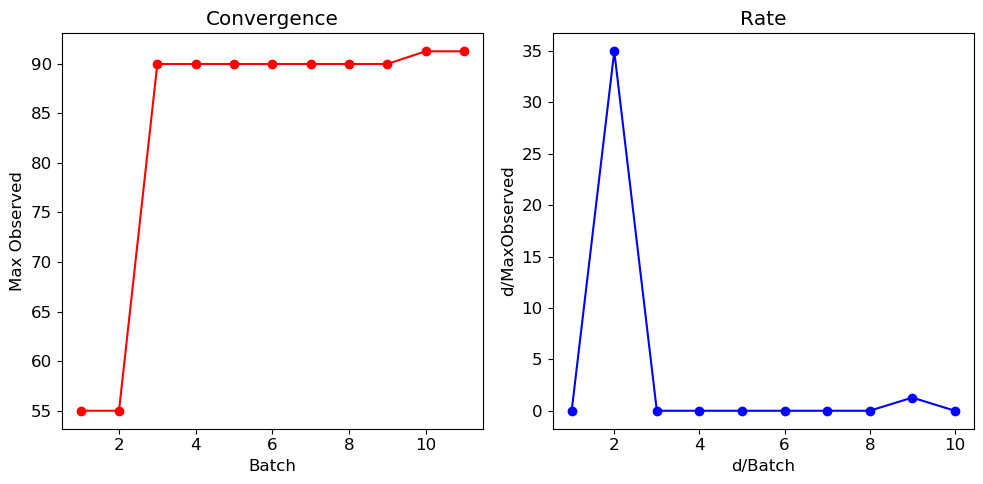

Model Performance:
RMSE: 15.069622994780525
R2_score: 0.5192677256430451

Actual GDT_TS:
0       76.92
1       38.38
2       70.54
3       91.89
4       55.45
        ...  
3999    92.57
4000    96.49
4001    95.05
4002    48.33
4003    82.08
Name: GDT_TS, Length: 4004, dtype: float64

Predicted GDT_TS:
[55.116077 42.414707 55.34576  ... 87.89091  44.475403 56.81119 ]


In [5]:
import matplotlib.pyplot as plt
from edbo.math_utils import model_performance

# Plot convergence
bo.plot_convergence()

acq_summary = bo.acquisition_summary()

# predicted GDT_TS
GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain)) # GP posterior mean
GDT_TS_pred_var = np.sqrt(bo.model.variance(bo.obj.domain)) * bo.obj.scaler.std * 2 # GP posterior variance

# true GDT_TS
GDT_TS_actual = casp15.data['GDT_TS']

RMSE, R2_score = model_performance(GDT_TS_pred_mu, GDT_TS_actual)

print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")

print("\nActual GDT_TS:")
print(GDT_TS_actual)

print("\nPredicted GDT_TS:")
print(GDT_TS_pred_mu)


True Maximum: 97.92
Predicted Maximum: 88.57660675048828


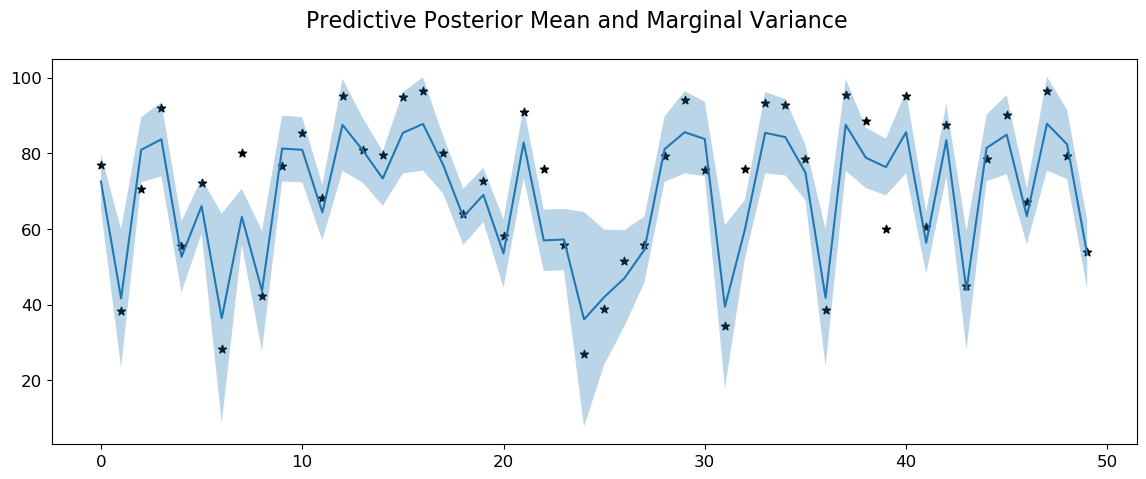

In [75]:
import matplotlib.pyplot as plt

x_star = range(4004)

num_pts = 50

#generate the plots
fig = plt.figure(figsize=(14,5))
fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
ax = fig.add_subplot(111)

ax.scatter(x_star[:num_pts], GDT_TS_actual[:num_pts], marker='*', color='k')
ax.plot(GDT_TS_pred_mu[:num_pts], color='C0')
ax.fill_between(x=x_star[:num_pts], y1=GDT_TS_pred_mu[:num_pts]+GDT_TS_pred_var[:num_pts], y2=GDT_TS_pred_mu[:num_pts]-GDT_TS_pred_var[:num_pts], alpha=0.3);

# predicted maxima
print(f"True Maximum: {max(GDT_TS_actual)}")
print(f"Predicted Maximum: {max(GDT_TS_pred_mu)}")

#### Strategy 1: Generate $x^*$ and plot $\mu$, $\sigma^2$ for 1 or 2 variables


In [71]:
#print(f"AL4_P ranges from {min(casp15.data['AL4_P'])} to {max(casp15.data['AL4_P'])}")
print(f"TM-score ranges from {min(casp15.data['TM-score'])} to {max(casp15.data['TM-score'])}")

TM-score ranges from 0.121 to 0.983


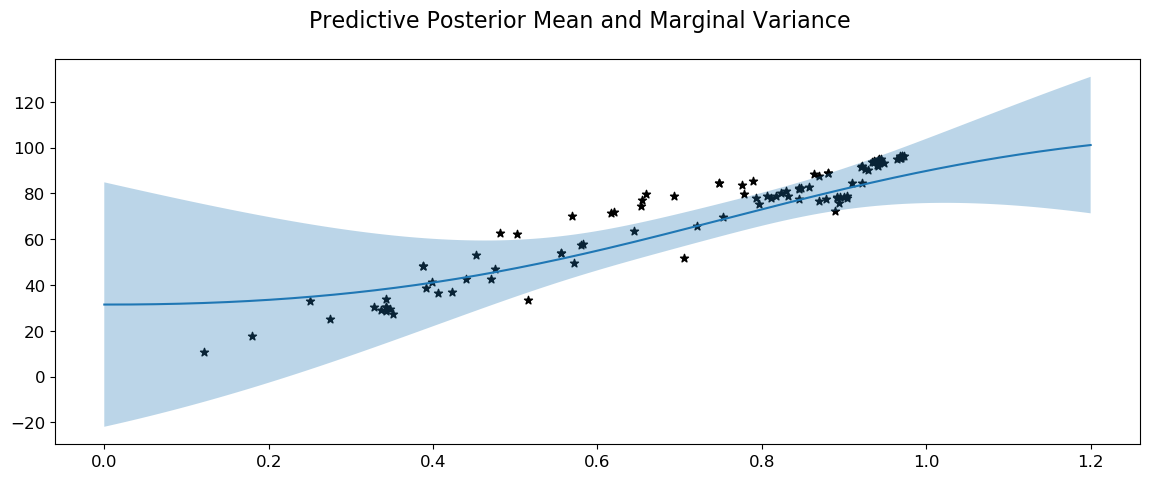

In [81]:
# this cell assumes that all columns have been dropped except for 1 feature
# (i.e., the domain is 1-dimensional)

samples = casp15.data.sample(n=100) # sample 5 points from the domain

domain_pts = samples['TM-score'].to_list()
output_pts = samples['GDT_TS'].to_list()

x_star = np.linspace(0, 1.2, 1000)

# predicted GDT_TS
GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance

#generate the plots
fig = plt.figure(figsize=(14,5))
fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
ax = fig.add_subplot(111)

ax.scatter(domain_pts, output_pts, marker='*', color='k')
ax.plot(x_star, GDT_TS_pred_mu, color='C0')
ax.fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, alpha=0.3);
ax.set(xlabel='TM-score', ylabel='GDT_TS')

### ALL ACQ FUNCTIONS


Running 1-D BO on feature AL0_P

Acquisition Function: TS...
BO complete!
Model Performance:
RMSE: 6.7657221458257135
R2_score: 0.9030993207429123

Acquisition Function: EI...
BO complete!
Model Performance:
RMSE: 5.840972258566291
R2_score: 0.9277781195417063

Acquisition Function: rand...
BO complete!
Model Performance:
RMSE: 5.048863730653202
R2_score: 0.9460382776159553

Acquisition Function: eps-greedy...
BO complete!
Model Performance:
RMSE: 5.881937279960146
R2_score: 0.9267615265658752

Acquisition Function: MeanMax...
BO complete!
Model Performance:
RMSE: 5.886290187167474
R2_score: 0.926653086700843

Acquisition Function: VarMax...
BO complete!
Model Performance:
RMSE: 7.6119620691348056
R2_score: 0.8773431701347694


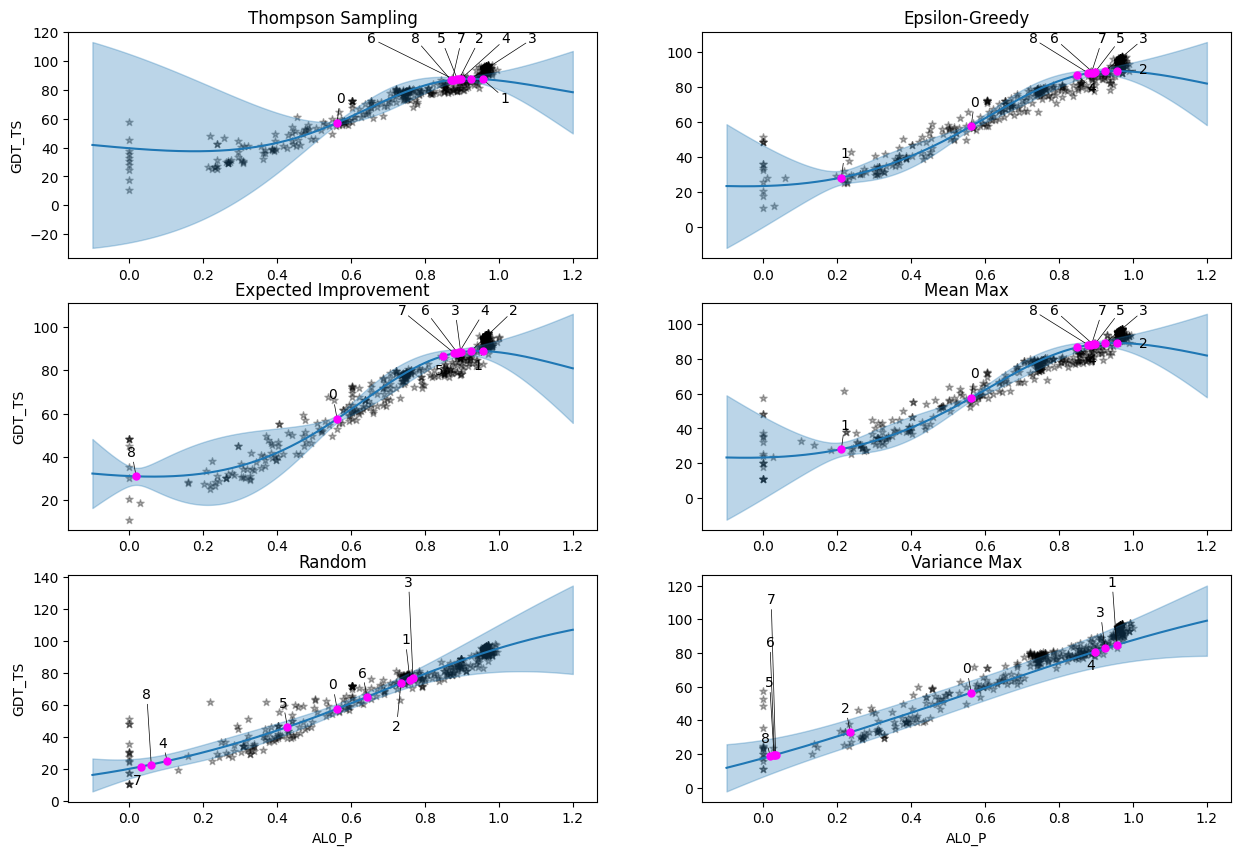

In [140]:
from edbo.bro import BO
from data_loader import load_CASP15
from edbo.math_utils import model_performance

#generate the plots
fig = plt.figure(figsize=(15,10))
#fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
fig.tight_layout()

axarr = fig.subplots(3, 2)

sp_idx = 0 # sub-plot index

acq_funcs = ['TS', 'EI', 'rand', 'eps-greedy', 'MeanMax', 'VarMax']

for c, col in enumerate(casp15.data.columns):
    if c > 0 or col == 'GDT_TS':
        break
    print(f"\nRunning 1-D BO on feature {col}")
    
    for a, acq_func in enumerate(acq_funcs):
        print(f"\nAcquisition Function: {acq_func}...")        
        exindex = Data(load_CASP15()) # start by making the entire dataset the exindex

        # then drop all columns except col
        columns_to_drop = exindex.data.columns.to_list()
        columns_to_drop.remove(col) # keep (i.e. don't drop) the specified current col
        columns_to_drop.remove('GDT_TS') # keep (i.e. don't drop) the output column

        exindex.drop(columns_to_drop)

        # standardise the column - need this for creating x_star later on
        exindex.standardize(target='GDT_TS')

        # Instantiate edbo.bro.BO
        bo = BO(exindex=exindex.data,                       # Experiment index to look up results from
                domain=exindex.data.drop('GDT_TS', axis=1), # Reaction space
                batch_size=1,                               # Choose 1 experiments on each iteraiton 
                acquisition_function=acq_func,                  # Use expected improvement/thompson sampling
                fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features

        # Run simulation
        bo.simulate(iterations=8, seed=0)   

        print("BO complete!")

        # proposed experiments from BO loop
        proposed_experiments = list(set(bo.obj.results[col].tolist()))
        acquisitions = bo.obj.scaler.unstandardize(bo.model.predict(proposed_experiments))
        
        
        # Model performance in approximating GDT_TS at the datapoints
        GDT_TS_actual = exindex.data['GDT_TS']
        GDT_TS_pred_pts = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))

        RMSE, R2_score = model_performance(GDT_TS_pred_pts, GDT_TS_actual)
        print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")

        # sample a fraction of the total datapoints from the domain to plot
        samples = exindex.data.sample(frac=0.1) 

        domain_pts = samples[col].to_list()
        output_pts = samples['GDT_TS'].to_list()

        # plot the predicted function over the "pseudo-continuous" (i.e. just 
        # high resolution, 2000 pts) input space, named x_star
        x_star = np.linspace(-0.1, 1.2, 2000) # assumes domain standardised to (0, 1)

        # predicted GDT_TS over domain x_star
        GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
        GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance

        i1 = sp_idx % 3 # 2D subplot array indexing
        i2 = sp_idx // 3 # 2D subplot array indexing
        
        acq_funcs_verbose = ['Thompson Sampling', 'Expected Improvement', 'Random', 'Epsilon-Greedy', 'Mean Max', 'Variance Max']
        
        # plots
        axarr[i1][i2].plot(x_star, GDT_TS_pred_mu, color='C0', label='Mean')
        axarr[i1][i2].scatter(domain_pts, output_pts, marker='*', color='k', s=30, alpha=0.3)
        axarr[i1][i2].fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, color='C0', alpha=0.3, label='Var');
        axarr[i1][i2].set(title=acq_funcs_verbose[a])
        if (i2 == 0):
            axarr[i1][i2].set(ylabel='GDT_TS')
        if (i1 == 2):
            axarr[i1][i2].set(xlabel=col)
        axarr[i1][i2].scatter(proposed_experiments, acquisitions, marker='o', color='magenta', s=25, zorder=10, label='acquisitions')

        # annotate the acquisition points
        idx = range(len(proposed_experiments))
        ss = [str(i) for i in idx] 
        texts = []
        for i in idx:
            t = axarr[i1][i2].text(x=proposed_experiments[i], y=acquisitions[i], s=ss[i])
            texts.append(t)
        adjust_text(texts, 
                    x=proposed_experiments, 
                    y=acquisitions,
                    ax=axarr[i1][i2],
                    expand=(2, 2),
                    force_text=(1, 1),
                    force_explode=(0.1, 5),
                    expand_axes=True,
                    only_move={"text": "xy", "static": "y", "explode": "y", "pull": "x"},
                    arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
                    )
        sp_idx += 1 # increment sub-plot index

plt.savefig('../../Report/Figures/BO_1D_AllAcqFuncs', bbox_inches='tight', pad_inches=0.1)

## 1D Plots - AL0_P, TM-score, DFM

### Thompson Sampling

In [ ]:
from edbo.bro import BO
from data_loader import load_CASP15
from edbo.math_utils import model_performance

#generate the plots
fig = plt.figure(figsize=(10,4))
#fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
#fig.tight_layout()
axarr = fig.subplots(1, 3)

sp_idx = 0 # sub-plot index

for col in casp15.data.columns:
    if col == 'GDT_TS':
        break
    print(f"\nRunning BO on feature {col}...")
    
    exindex = Data(load_CASP15()) # start by making the entire dataset the exindex
    
    # then drop all columns except col
    columns_to_drop = exindex.data.columns.to_list()
    columns_to_drop.remove(col) # keep (i.e. don't drop) the specified current col
    columns_to_drop.remove('GDT_TS') # keep (i.e. don't drop) the output column
    
    exindex.drop(columns_to_drop)
    
    # standardise the column - need this for creating x_star later on
    exindex.standardize(target='GDT_TS')
    
    # Instantiate edbo.bro.BO
    bo = BO(exindex=exindex.data,                       # Experiment index to look up results from
            domain=exindex.data.drop('GDT_TS', axis=1), # Reaction space
            batch_size=1,                               # Choose 1 experiments on each iteraiton 
            acquisition_function='TS',                  # Use expected improvement/thompson sampling
            fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features
    
    # Run simulation
    bo.simulate(iterations=8, seed=0)   
        
    print("BO complete!")

    # proposed experiments from BO loop
    proposed_experiments = list(set(bo.obj.results[col].tolist()))
    acquisitions = bo.obj.scaler.unstandardize(bo.model.predict(proposed_experiments))
    
    # Model performance in approximating GDT_TS at the datapoints
    GDT_TS_actual = exindex.data['GDT_TS']
    GDT_TS_pred_pts = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))
    
    RMSE, R2_score = model_performance(GDT_TS_pred_pts, GDT_TS_actual)
    print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")
    
    # sample a fraction of the total datapoints from the domain to plot
    samples = exindex.data.sample(frac=0.1) 

    domain_pts = samples[col].to_list()
    output_pts = samples['GDT_TS'].to_list()
    
    # plot the predicted function over the "pseudo-continuous" (i.e. just 
    # high resolution, 2000 pts) input space, named x_star
    x_star = np.linspace(-0.1, 1.2, 2000) # assumes domain standardised to (0, 1)
    
    # predicted GDT_TS over domain x_star
    GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
    GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance 

    # plots
    axarr[sp_idx].plot(x_star, GDT_TS_pred_mu, color='C0', label='Mean')
    axarr[sp_idx].scatter(domain_pts, output_pts, marker='*', color='k', s=30, alpha=0.3)
    axarr[sp_idx].fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, color='C0', alpha=0.3, label='Var');
    axarr[sp_idx].set(xlabel=col)
    if (sp_idx == 0):
        axarr[sp_idx].set(ylabel='GDT_TS')
    #axarr[i1][i2].set(xlabel=col, ylabel='GDT_TS')
    axarr[sp_idx].scatter(proposed_experiments, acquisitions, marker='o', color='magenta', s=25, zorder=10, label='acquisitions')
    
    # annotate the acquisition points
    idx = range(len(proposed_experiments))
    ss = [str(i) for i in idx] 
    texts = []
    for i in idx:
        t = axarr[i1][i2].text(x=proposed_experiments[i], y=acquisitions[i], s=ss[i])
        texts.append(t)
    adjust_text(texts, 
                x=proposed_experiments, 
                y=acquisitions,
                ax=axarr[sp_idx],
                expand=(2, 2),
                force_text=(1, 1),
                force_explode=(0.1, 5),
                expand_axes=True,
                only_move={"text": "xy", "static": "y", "explode": "y", "pull": "x"},
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
                )
    
    sp_idx += 1

plt.savefig('../../Report/Figures/BO_1D_ThompsonSampling_final', bbox_inches='tight', pad_inches=0.1)

### Expected Improvement

### Epsilon-Greedy

## 1D Plots - ALL Features

### Thompson Sampling


Running BO on feature AL0_P...
BO complete!
Model Performance:
RMSE: 6.7657221458257135
R2_score: 0.9030993207429123

Running BO on feature TM-score...
BO complete!
Model Performance:
RMSE: 9.411679779799885
R2_score: 0.8124863922060128

Running BO on feature TM-align...
BO complete!
Model Performance:
RMSE: 8.289437323927812
R2_score: 0.8545383165801885

Running BO on feature AL4_P...
BO complete!
Model Performance:
RMSE: 9.647434632872592
R2_score: 0.8029746107434592

Running BO on feature QCS...
BO complete!
Model Performance:
RMSE: 22.880473286969657
R2_score: -0.1082264526038621

Running BO on feature Z-score...
BO complete!
Model Performance:
RMSE: 29.506114170078533
R2_score: -0.8429881463658111

Running BO on feature SS...
BO complete!
Model Performance:
RMSE: 23.79851587471529
R2_score: -0.19894221945427693

Running BO on feature DFM...
BO complete!
Model Performance:
RMSE: 13.728652538491346
R2_score: 0.6010170547566144


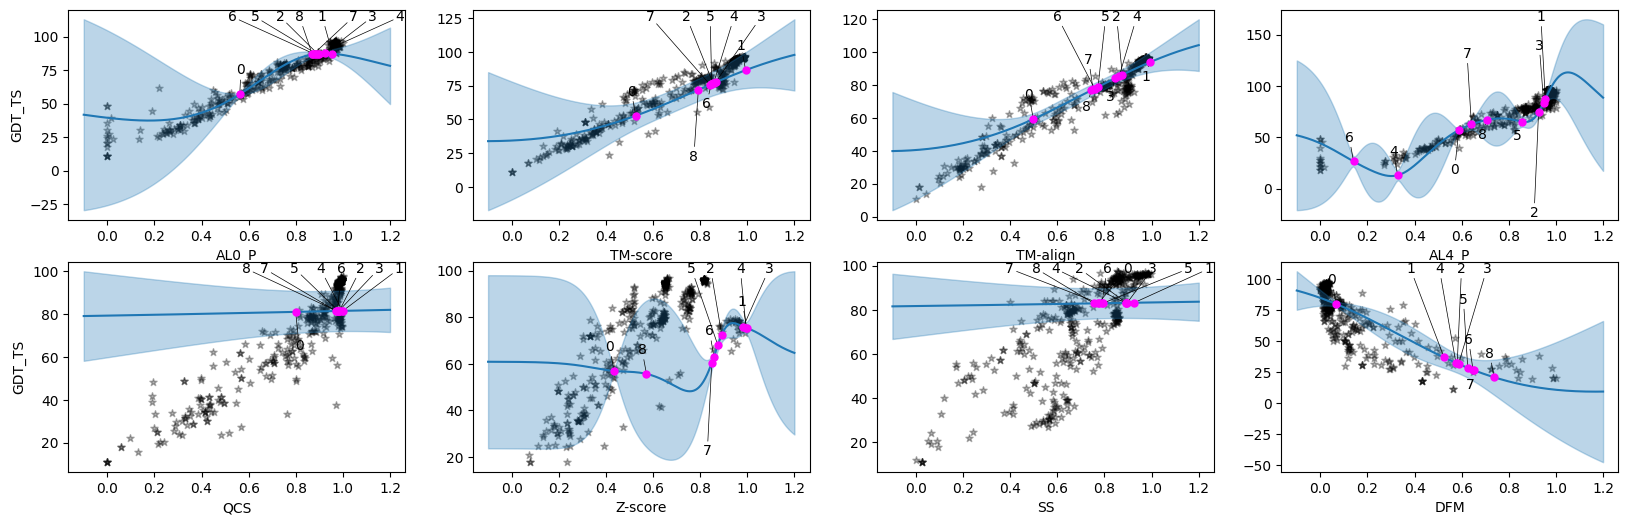

In [148]:
from edbo.bro import BO
from data_loader import load_CASP15
from edbo.math_utils import model_performance

#generate the plots
fig = plt.figure(figsize=(20,6))
#fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
fig.tight_layout()
axarr = fig.subplots(2, 4)

sp_idx = 0 # sub-plot index

for col in casp15.data.columns:
    if col == 'GDT_TS':
        break
    print(f"\nRunning BO on feature {col}...")
    
    exindex = Data(load_CASP15()) # start by making the entire dataset the exindex
    
    # then drop all columns except col
    columns_to_drop = exindex.data.columns.to_list()
    columns_to_drop.remove(col) # keep (i.e. don't drop) the specified current col
    columns_to_drop.remove('GDT_TS') # keep (i.e. don't drop) the output column
    
    exindex.drop(columns_to_drop)
    
    # standardise the column - need this for creating x_star later on
    exindex.standardize(target='GDT_TS')
    
    # Instantiate edbo.bro.BO
    bo = BO(exindex=exindex.data,                       # Experiment index to look up results from
            domain=exindex.data.drop('GDT_TS', axis=1), # Reaction space
            batch_size=1,                               # Choose 1 experiments on each iteraiton 
            acquisition_function='TS',                  # Use expected improvement/thompson sampling
            fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features
    
    # Run simulation
    bo.simulate(iterations=8, seed=0)   
        
    print("BO complete!")

    # proposed experiments from BO loop
    proposed_experiments = list(set(bo.obj.results[col].tolist()))
    acquisitions = bo.obj.scaler.unstandardize(bo.model.predict(proposed_experiments))
    
    # Model performance in approximating GDT_TS at the datapoints
    GDT_TS_actual = exindex.data['GDT_TS']
    GDT_TS_pred_pts = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))
    
    RMSE, R2_score = model_performance(GDT_TS_pred_pts, GDT_TS_actual)
    print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")
    
    # sample a fraction of the total datapoints from the domain to plot
    samples = exindex.data.sample(frac=0.1) 

    domain_pts = samples[col].to_list()
    output_pts = samples['GDT_TS'].to_list()
    
    # plot the predicted function over the "pseudo-continuous" (i.e. just 
    # high resolution, 2000 pts) input space, named x_star
    x_star = np.linspace(-0.1, 1.2, 2000) # assumes domain standardised to (0, 1)
    
    # predicted GDT_TS over domain x_star
    GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
    GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance
    
    i1 = sp_idx // 4 # 2D subplot array indexing
    i2 = sp_idx % 4 # 2D subplot array indexing
    
    # plots
    axarr[i1][i2].plot(x_star, GDT_TS_pred_mu, color='C0', label='Mean')
    axarr[i1][i2].scatter(domain_pts, output_pts, marker='*', color='k', s=30, alpha=0.3)
    axarr[i1][i2].fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, color='C0', alpha=0.3, label='Var');
    axarr[i1][i2].set(xlabel=col)
    if (i2 == 0):
        axarr[i1][i2].set(ylabel='GDT_TS')
    #axarr[i1][i2].set(xlabel=col, ylabel='GDT_TS')
    axarr[i1][i2].scatter(proposed_experiments, acquisitions, marker='o', color='magenta', s=25, zorder=10, label='acquisitions')
    
    # annotate the acquisition points
    idx = range(len(proposed_experiments))
    ss = [str(i) for i in idx] 
    texts = []
    for i in idx:
        t = axarr[i1][i2].text(x=proposed_experiments[i], y=acquisitions[i], s=ss[i])
        texts.append(t)
    adjust_text(texts, 
                x=proposed_experiments, 
                y=acquisitions,
                ax=axarr[i1][i2],
                expand=(2, 2),
                force_text=(1, 1),
                force_explode=(0.1, 5),
                expand_axes=True,
                only_move={"text": "xy", "static": "y", "explode": "y", "pull": "x"},
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
                )
    
    sp_idx += 1

plt.savefig('../../Report/Figures/BO_1D_ThompsonSampling', bbox_inches='tight', pad_inches=0.1)

### Expected Improvement


Running BO on feature AL0_P...
BO complete!
Model Performance:
RMSE: 5.840972258566291
R2_score: 0.9277781195417063

Running BO on feature TM-score...
BO complete!
Model Performance:
RMSE: 9.145903329872315
R2_score: 0.8229272556389541

Running BO on feature TM-align...
BO complete!
Model Performance:
RMSE: 6.399088715295303
R2_score: 0.9133168335639302

Running BO on feature AL4_P...
BO complete!
Model Performance:
RMSE: 7.682855749494936
R2_score: 0.8750478126352627

Running BO on feature QCS...
BO complete!
Model Performance:
RMSE: 8.397661508809898
R2_score: 0.8507153221388686

Running BO on feature Z-score...
BO complete!
Model Performance:
RMSE: 19.403993598626304
R2_score: 0.20295883837164574

Running BO on feature SS...
BO complete!
Model Performance:
RMSE: 14.659789560520464
R2_score: 0.5450601531137179

Running BO on feature DFM...
BO complete!
Model Performance:
RMSE: 13.354320819753681
R2_score: 0.6224781299270241


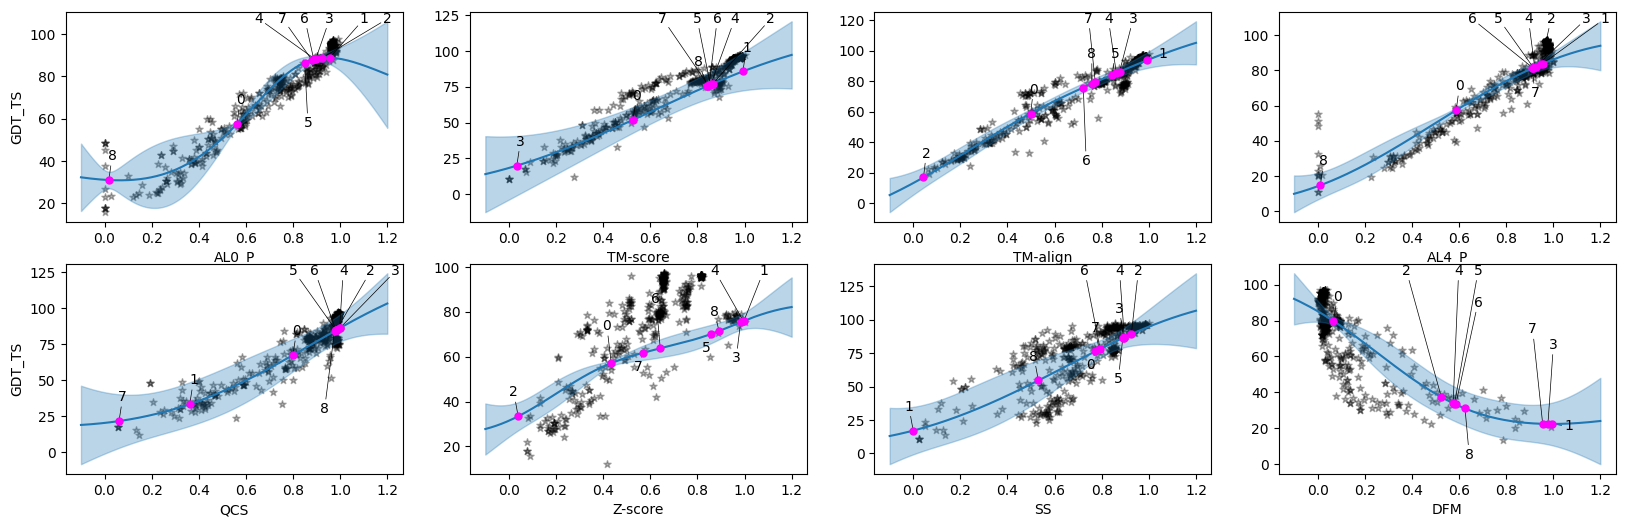

In [149]:
from edbo.bro import BO
from data_loader import load_CASP15
from edbo.math_utils import model_performance

#generate the plots
fig = plt.figure(figsize=(20,6))
#fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
fig.tight_layout()
axarr = fig.subplots(2, 4)

sp_idx = 0 # sub-plot index

for col in casp15.data.columns:
    if col == 'GDT_TS':
        break
    print(f"\nRunning BO on feature {col}...")
    
    exindex = Data(load_CASP15()) # start by making the entire dataset the exindex
    
    # then drop all columns except col
    columns_to_drop = exindex.data.columns.to_list()
    columns_to_drop.remove(col) # keep (i.e. don't drop) the specified current col
    columns_to_drop.remove('GDT_TS') # keep (i.e. don't drop) the output column
    
    exindex.drop(columns_to_drop)
    
    # standardise the column - need this for creating x_star later on
    exindex.standardize(target='GDT_TS')
    
    # Instantiate edbo.bro.BO
    bo = BO(exindex=exindex.data,                       # Experiment index to look up results from
            domain=exindex.data.drop('GDT_TS', axis=1), # Reaction space
            batch_size=1,                               # Choose 1 experiments on each iteraiton 
            acquisition_function='EI',                  # Use expected improvement/thompson sampling
            fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features
    
    # Run simulation
    bo.simulate(iterations=8, seed=0)   
        
    print("BO complete!")

    # proposed experiments from BO loop
    proposed_experiments = list(set(bo.obj.results[col].tolist()))
    acquisitions = bo.obj.scaler.unstandardize(bo.model.predict(proposed_experiments))
    
    # Model performance in approximating GDT_TS at the datapoints
    GDT_TS_actual = exindex.data['GDT_TS']
    GDT_TS_pred_pts = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))
    
    RMSE, R2_score = model_performance(GDT_TS_pred_pts, GDT_TS_actual)
    print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")
    
    # sample a fraction of the total datapoints from the domain to plot
    samples = exindex.data.sample(frac=0.1) 

    domain_pts = samples[col].to_list()
    output_pts = samples['GDT_TS'].to_list()
    
    # plot the predicted function over the "pseudo-continuous" (i.e. just 
    # high resolution, 2000 pts) input space, named x_star
    x_star = np.linspace(-0.1, 1.2, 2000) # assumes domain standardised to (0, 1)
    
    # predicted GDT_TS over domain x_star
    GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
    GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance
    
    i1 = sp_idx // 4 # 2D subplot array indexing
    i2 = sp_idx % 4 # 2D subplot array indexing
    
    # plots
    axarr[i1][i2].plot(x_star, GDT_TS_pred_mu, color='C0', label='Mean')
    axarr[i1][i2].scatter(domain_pts, output_pts, marker='*', color='k', s=30, alpha=0.3)
    axarr[i1][i2].fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, color='C0', alpha=0.3, label='Var');
    axarr[i1][i2].set(xlabel=col)
    if (i2 == 0):
        axarr[i1][i2].set(ylabel='GDT_TS')
    #axarr[i1][i2].set(xlabel=col, ylabel='GDT_TS')
    axarr[i1][i2].scatter(proposed_experiments, acquisitions, marker='o', color='magenta', s=25, zorder=10, label='acquisitions')
    
    # annotate the acquisition points
    idx = range(len(proposed_experiments))
    ss = [str(i) for i in idx] 
    texts = []
    for i in idx:
        t = axarr[i1][i2].text(x=proposed_experiments[i], y=acquisitions[i], s=ss[i])
        texts.append(t)
    adjust_text(texts, 
                x=proposed_experiments, 
                y=acquisitions,
                ax=axarr[i1][i2],
                expand=(2, 2),
                force_text=(1, 1),
                force_explode=(0.1, 5),
                expand_axes=True,
                only_move={"text": "xy", "static": "y", "explode": "y", "pull": "x"},
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
                )
    
    sp_idx += 1

plt.savefig('../../Report/Figures/BO_1D_ExpectedImprovement', bbox_inches='tight', pad_inches=0.1)

### Epsilon-Greedy


Running BO on feature AL0_P...
BO complete!
Model Performance:
RMSE: 5.881937279960146
R2_score: 0.9267615265658752

Running BO on feature TM-score...
BO complete!
Model Performance:
RMSE: 10.09760887228856
R2_score: 0.7841581803016484

Running BO on feature TM-align...
BO complete!
Model Performance:
RMSE: 6.6057260956383095
R2_score: 0.9076281527777269

Running BO on feature AL4_P...
BO complete!
Model Performance:
RMSE: 7.873543268182025
R2_score: 0.8687682434939307

Running BO on feature QCS...
BO complete!
Model Performance:
RMSE: 8.545821571693905
R2_score: 0.8454011899670064

Running BO on feature Z-score...
BO complete!
Model Performance:
RMSE: 18.673814552337674
R2_score: 0.2618160674595049

Running BO on feature SS...
BO complete!
Model Performance:
RMSE: 14.448135294287948
R2_score: 0.5581019303179127

Running BO on feature DFM...
BO complete!
Model Performance:
RMSE: 13.728761138585421
R2_score: 0.6010107424464084


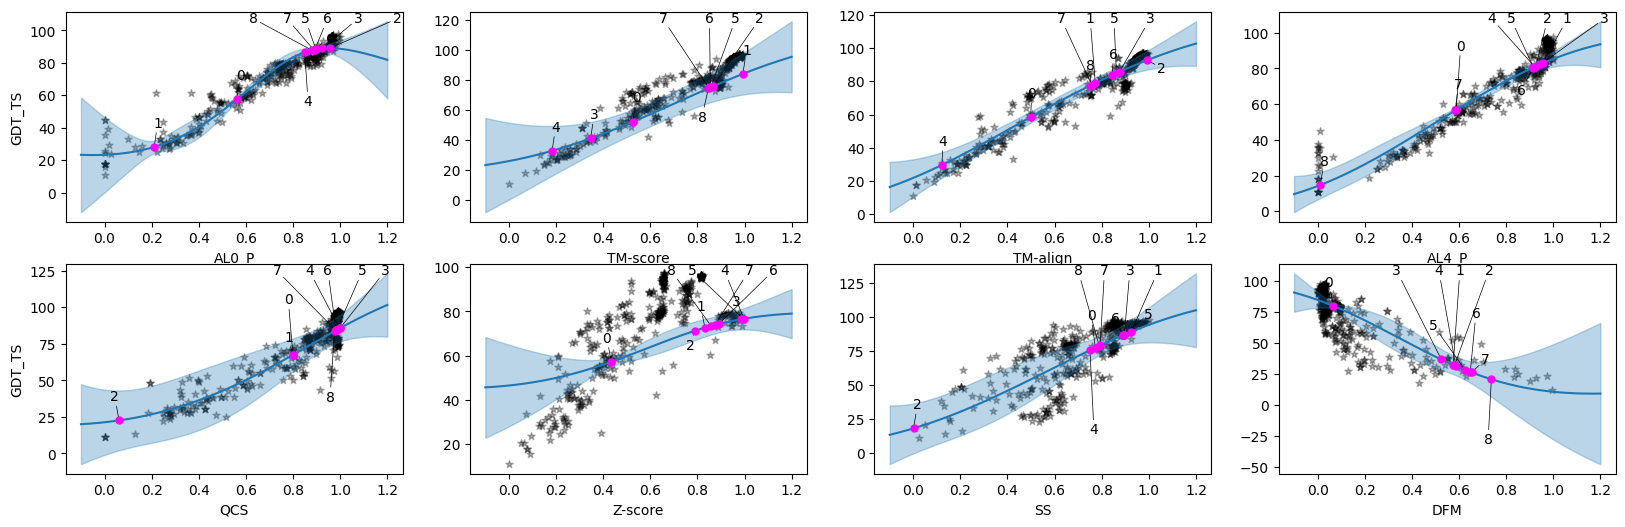

In [150]:
from edbo.bro import BO
from data_loader import load_CASP15
from edbo.math_utils import model_performance

#generate the plots
fig = plt.figure(figsize=(20,6))
#fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
fig.tight_layout()
axarr = fig.subplots(2, 4)

sp_idx = 0 # sub-plot index

for col in casp15.data.columns:
    if col == 'GDT_TS':
        break
    print(f"\nRunning BO on feature {col}...")
    
    exindex = Data(load_CASP15()) # start by making the entire dataset the exindex
    
    # then drop all columns except col
    columns_to_drop = exindex.data.columns.to_list()
    columns_to_drop.remove(col) # keep (i.e. don't drop) the specified current col
    columns_to_drop.remove('GDT_TS') # keep (i.e. don't drop) the output column
    
    exindex.drop(columns_to_drop)
    
    # standardise the column - need this for creating x_star later on
    exindex.standardize(target='GDT_TS')
    
    # Instantiate edbo.bro.BO
    bo = BO(exindex=exindex.data,                       # Experiment index to look up results from
            domain=exindex.data.drop('GDT_TS', axis=1), # Reaction space
            batch_size=1,                               # Choose 1 experiments on each iteraiton 
            acquisition_function='eps-greedy',                  # Use expected improvement/thompson sampling
            fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features
    
    # Run simulation
    bo.simulate(iterations=8, seed=0)   
        
    print("BO complete!")

    # proposed experiments from BO loop
    proposed_experiments = list(set(bo.obj.results[col].tolist()))
    acquisitions = bo.obj.scaler.unstandardize(bo.model.predict(proposed_experiments))
    
    # Model performance in approximating GDT_TS at the datapoints
    GDT_TS_actual = exindex.data['GDT_TS']
    GDT_TS_pred_pts = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))
    
    RMSE, R2_score = model_performance(GDT_TS_pred_pts, GDT_TS_actual)
    print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")
    
    # sample a fraction of the total datapoints from the domain to plot
    samples = exindex.data.sample(frac=0.1) 

    domain_pts = samples[col].to_list()
    output_pts = samples['GDT_TS'].to_list()
    
    # plot the predicted function over the "pseudo-continuous" (i.e. just 
    # high resolution, 2000 pts) input space, named x_star
    x_star = np.linspace(-0.1, 1.2, 2000) # assumes domain standardised to (0, 1)
    
    # predicted GDT_TS over domain x_star
    GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
    GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance
    
    i1 = sp_idx // 4 # 2D subplot array indexing
    i2 = sp_idx % 4 # 2D subplot array indexing
    
    # plots
    axarr[i1][i2].plot(x_star, GDT_TS_pred_mu, color='C0', label='Mean')
    axarr[i1][i2].scatter(domain_pts, output_pts, marker='*', color='k', s=30, alpha=0.3)
    axarr[i1][i2].fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, color='C0', alpha=0.3, label='Var');
    axarr[i1][i2].set(xlabel=col)
    if (i2 == 0):
        axarr[i1][i2].set(ylabel='GDT_TS')
    #axarr[i1][i2].set(xlabel=col, ylabel='GDT_TS')
    axarr[i1][i2].scatter(proposed_experiments, acquisitions, marker='o', color='magenta', s=25, zorder=10, label='acquisitions')
    
    # annotate the acquisition points
    idx = range(len(proposed_experiments))
    ss = [str(i) for i in idx] 
    texts = []
    for i in idx:
        t = axarr[i1][i2].text(x=proposed_experiments[i], y=acquisitions[i], s=ss[i])
        texts.append(t)
    adjust_text(texts, 
                x=proposed_experiments, 
                y=acquisitions,
                ax=axarr[i1][i2],
                expand=(2, 2),
                force_text=(1, 1),
                force_explode=(0.1, 5),
                expand_axes=True,
                only_move={"text": "xy", "static": "y", "explode": "y", "pull": "x"},
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
                )
    
    sp_idx += 1

plt.savefig('../../Report/Figures/BO_1D_Epsilon_Greedy', bbox_inches='tight', pad_inches=0.1)

### Mean Max


Running BO on feature AL0_P...
BO complete!
Model Performance:
RMSE: 5.886290187167474
R2_score: 0.926653086700843

Running BO on feature AL4_P...
BO complete!
Model Performance:
RMSE: 8.804243625449002
R2_score: 0.8359098137189521

Running BO on feature QCS...
BO complete!
Model Performance:
RMSE: 8.541314555882796
R2_score: 0.8455642159643818

Running BO on feature Z-score...
BO complete!
Model Performance:
RMSE: 18.659773073143718
R2_score: 0.2629257815277426


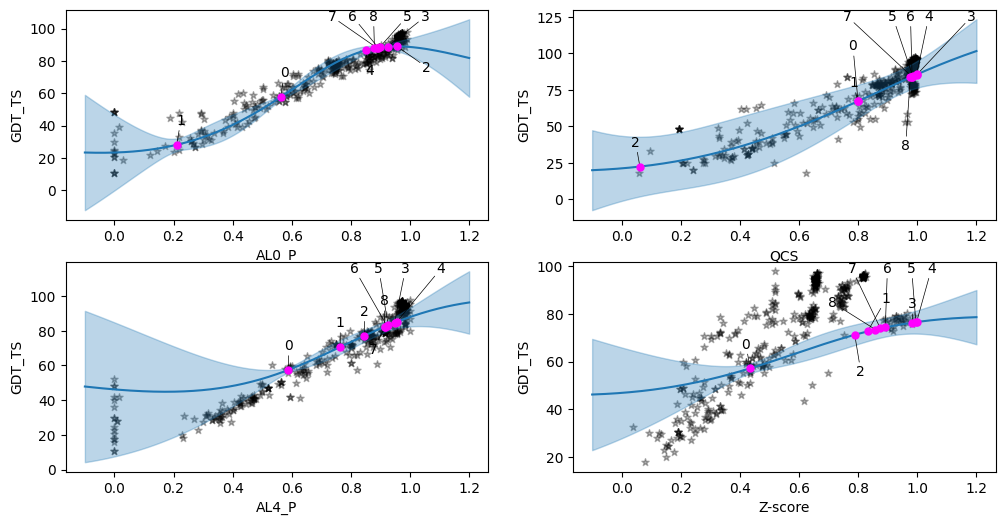

In [112]:
from edbo.bro import BO
from data_loader import load_CASP15
from edbo.math_utils import model_performance

#generate the plots
fig = plt.figure(figsize=(12,6))
#fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)

axarr = fig.subplots(2, 2)

sp_idx = 0 # sub-plot index

for col in casp15.data.columns:
    if col == 'GDT_TS':
        break
    print(f"\nRunning BO on feature {col}...")
    
    exindex = Data(load_CASP15()) # start by making the entire dataset the exindex
    
    # then drop all columns except col
    columns_to_drop = exindex.data.columns.to_list()
    columns_to_drop.remove(col) # keep (i.e. don't drop) the specified current col
    columns_to_drop.remove('GDT_TS') # keep (i.e. don't drop) the output column
    
    exindex.drop(columns_to_drop)
    
    # standardise the column - need this for creating x_star later on
    exindex.standardize(target='GDT_TS')
    
    # Instantiate edbo.bro.BO
    bo = BO(exindex=exindex.data,                       # Experiment index to look up results from
            domain=exindex.data.drop('GDT_TS', axis=1), # Reaction space
            batch_size=1,                               # Choose 1 experiments on each iteraiton 
            acquisition_function='MeanMax',             # Use expected improvement/thompson sampling
            fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features
    
    # Run simulation
    bo.simulate(iterations=8, seed=0)   
        
    print("BO complete!")

    # proposed experiments from BO loop
    proposed_experiments = list(set(bo.obj.results[col].tolist()))
    acquisitions = bo.obj.scaler.unstandardize(bo.model.predict(proposed_experiments))
    
    # Model performance in approximating GDT_TS at the datapoints
    GDT_TS_actual = exindex.data['GDT_TS']
    GDT_TS_pred_pts = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))
    
    RMSE, R2_score = model_performance(GDT_TS_pred_pts, GDT_TS_actual)
    print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")
    
    # sample a fraction of the total datapoints from the domain to plot
    samples = exindex.data.sample(frac=0.1) 

    domain_pts = samples[col].to_list()
    output_pts = samples['GDT_TS'].to_list()
    
    # plot the predicted function over the "pseudo-continuous" (i.e. just 
    # high resolution, 2000 pts) input space, named x_star
    x_star = np.linspace(-0.1, 1.2, 2000) # assumes domain standardised to (0, 1)
    
    # predicted GDT_TS over domain x_star
    GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
    GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance
    
    i1 = sp_idx % 2 # 2D subplot array indexing
    i2 = sp_idx // 2 # 2D subplot array indexing
    
    # plots
    axarr[i1][i2].plot(x_star, GDT_TS_pred_mu, color='C0', label='Mean')
    axarr[i1][i2].scatter(domain_pts, output_pts, marker='*', color='k', s=30, alpha=0.3)
    axarr[i1][i2].fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, color='C0', alpha=0.3, label='Var');
    axarr[i1][i2].set(xlabel=col, ylabel='GDT_TS')
    axarr[i1][i2].scatter(proposed_experiments, acquisitions, marker='o', color='magenta', s=25, zorder=10, label='acquisitions')
    
    # annotate the acquisition points
    idx = range(len(proposed_experiments))
    ss = [str(i) for i in idx] 
    texts = []
    for i in idx:
        t = axarr[i1][i2].text(x=proposed_experiments[i], y=acquisitions[i], s=ss[i])
        texts.append(t)
    adjust_text(texts, 
                x=proposed_experiments, 
                y=acquisitions,
                ax=axarr[i1][i2],
                expand=(2, 2),
                force_text=(1, 1),
                force_explode=(0.1, 5),
                expand_axes=True,
                only_move={"text": "xy", "static": "y", "explode": "y", "pull": "x"},
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
                )
    
    sp_idx += 1

plt.savefig('../../Report/Figures/BO_1D_MeanMax', bbox_inches='tight', pad_inches=0.1)

### VarMax


Running BO on feature AL0_P...
BO complete!
Model Performance:
RMSE: 7.6119620691348056
R2_score: 0.8773431701347694

Running BO on feature AL4_P...
BO complete!
Model Performance:
RMSE: 7.444044570864907
R2_score: 0.8826950241412032

Running BO on feature QCS...
BO complete!
Model Performance:
RMSE: 10.391128890778173
R2_score: 0.7714275051933228

Running BO on feature Z-score...
BO complete!
Model Performance:
RMSE: 24.780678343303347
R2_score: -0.2999447247302689


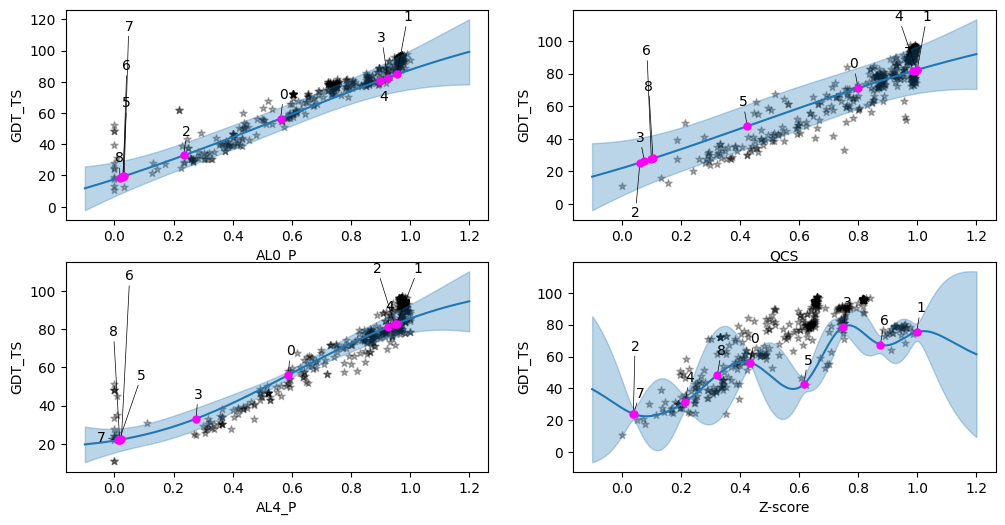

In [113]:
from edbo.bro import BO
from data_loader import load_CASP15
from edbo.math_utils import model_performance

#generate the plots
fig = plt.figure(figsize=(12,6))
#fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)

axarr = fig.subplots(1, 1)

sp_idx = 0 # sub-plot index

for col in casp15.data.columns:
    if col == 'GDT_TS':
        break
    print(f"\nRunning BO on feature {col}...")
    
    exindex = Data(load_CASP15()) # start by making the entire dataset the exindex
    
    # then drop all columns except col
    columns_to_drop = exindex.data.columns.to_list()
    columns_to_drop.remove(col) # keep (i.e. don't drop) the specified current col
    columns_to_drop.remove('GDT_TS') # keep (i.e. don't drop) the output column
    
    exindex.drop(columns_to_drop)
    
    # standardise the column - need this for creating x_star later on
    exindex.standardize(target='GDT_TS')
    
    # Instantiate edbo.bro.BO
    bo = BO(exindex=exindex.data,                       # Experiment index to look up results from
            domain=exindex.data.drop('GDT_TS', axis=1), # Reaction space
            batch_size=1,                               # Choose 1 experiments on each iteraiton 
            acquisition_function='VarMax',              # Use expected improvement/thompson sampling
            fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features
    
    # Run simulation
    bo.simulate(iterations=8, seed=0)   
        
    print("BO complete!")

    # proposed experiments from BO loop
    proposed_experiments = list(set(bo.obj.results[col].tolist()))
    acquisitions = bo.obj.scaler.unstandardize(bo.model.predict(proposed_experiments))
    
    # Model performance in approximating GDT_TS at the datapoints
    GDT_TS_actual = exindex.data['GDT_TS']
    GDT_TS_pred_pts = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))
    
    RMSE, R2_score = model_performance(GDT_TS_pred_pts, GDT_TS_actual)
    print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")
    
    # sample a fraction of the total datapoints from the domain to plot
    samples = exindex.data.sample(frac=0.1) 

    domain_pts = samples[col].to_list()
    output_pts = samples['GDT_TS'].to_list()
    
    # plot the predicted function over the "pseudo-continuous" (i.e. just 
    # high resolution, 2000 pts) input space, named x_star
    x_star = np.linspace(-0.1, 1.2, 2000) # assumes domain standardised to (0, 1)
    
    # predicted GDT_TS over domain x_star
    GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
    GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance
    
    i1 = sp_idx % 2 # 2D subplot array indexing
    i2 = sp_idx // 2 # 2D subplot array indexing
    
    # plots
    axarr[i1][i2].plot(x_star, GDT_TS_pred_mu, color='C0', label='Mean')
    axarr[i1][i2].scatter(domain_pts, output_pts, marker='*', color='k', s=30, alpha=0.3)
    axarr[i1][i2].fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, color='C0', alpha=0.3, label='Var');
    axarr[i1][i2].set(xlabel=col, ylabel='GDT_TS')
    axarr[i1][i2].scatter(proposed_experiments, acquisitions, marker='o', color='magenta', s=25, zorder=10, label='acquisitions')
    
    # annotate the acquisition points
    idx = range(len(proposed_experiments))
    ss = [str(i) for i in idx] 
    texts = []
    for i in idx:
        t = axarr[i1][i2].text(x=proposed_experiments[i], y=acquisitions[i], s=ss[i])
        texts.append(t)
    adjust_text(texts, 
                x=proposed_experiments, 
                y=acquisitions,
                ax=axarr[i1][i2],
                expand=(2, 2),
                force_text=(1, 1),
                force_explode=(0.1, 5),
                expand_axes=True,
                only_move={"text": "xy", "static": "y", "explode": "y", "pull": "x"},
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
                )
    
    sp_idx += 1

plt.savefig('../../Report/Figures/BO_1D_VarMax', bbox_inches='tight', pad_inches=0.1)

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from edbo.math_utils import pca

xx = casp15.data['AL4_P']
yy = casp15.data['TM-align']
zz = casp15.data['GDT_TS']

#creating figure
fig = plt.figure()
ax = Axes3D(fig)
 
#creating the plot
two_var_plot = ax.scatter3D(xx, yy, zz, c=zz, cmap='viridis');

#### Strategy 2: Run PCA and generate x* along the axis of the principle component

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from edbo.math_utils import pca

# Run PCA on the dataset
explained_variance = pca(bo.obj.domain, n_components=2)

print(explained_variance)

xx = explained_variance['pc2']
yy = explained_variance['pc2']
zz = GDT_TS_actual

# creating figure
fig = plt.figure()
ax = Axes3D(fig)
 
# creating the plot
pca_plot = ax.scatter3D(xx, yy, zz, c=zz, cmap='viridis');
ax.contour(xx, yy, zz, c=zz, cmap='viridis')

In [ ]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                        # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=1,                               # Choose 1 experiments on each iteraiton 
        acquisition_function='TS',                  # Use expected improvement
        init_method='rand',
        fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

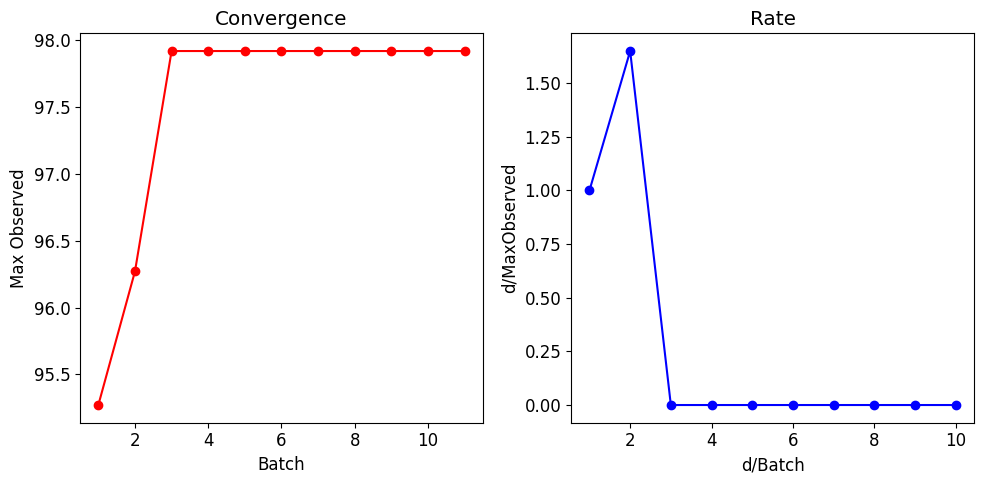

In [33]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                      # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=20,                          # Choose 20 experiments on each iteraiton 
        acquisition_function='TS',              # Use expected improvement
        fast_comp=True)                         # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

### Simulations

In [9]:
from edbo.models import GP_Model, RF_Model, Random
from edbo.plot_utils import average_convergence, plot_avg_convergence
import pandas as pd

# Function for simulating different BO parameters

def simulate(data,                 # Data container (vide supra)
             acq_func,             # Acquisition function: 'EI', 'PI', 'UCB', 'TS', ...
             model=GP_Model,       # Surrogate model: GP_Model or RF_Model
             init_method='rand',   # Initialization method: 'rand', 'pam', 'kmeans'
             batch_size=1,        # Parallel acquisition: int
             iterations=9,         # Number of iterations to run each simulation for
             average_of=10,        # Number of simulations to average
             export_path=None,     # Export the simulation results to a CSV file
             plot=False):          # Plot the average and standard deviation averaged convergence
    """
    Simulation function which averages BO runs with given optimization paramters.
    """
    
    # Average N optimizations with different random initializations
    results = []
    for i in range(average_of):
        
        #print(f"Experiment {i+1}/{average_of}...")
        
        # Use random function if the acquisition function is random selection
        if acq_func == 'rand':
            bo = BO(exindex=data.data,
                    domain=data.data.drop('GDT_TS', axis=1),
                    init_method=init_method,
                    model=Random,
                    batch_size=batch_size,
                    acquisition_function=acq_func)
        # Otherwise use specified model
        else:
            bo = BO(exindex=data.data,
                    domain=data.data.drop('GDT_TS', axis=1),
                    model=model,
                    init_method=init_method,
                    batch_size=batch_size,
                    acquisition_function=acq_func,
                    fast_comp=True)                            # Use gpytorch fast computation features
            
        # Simulate
        bo.init_seq.visualize = True
        bo.simulate(iterations=iterations, seed=i)
        
        # Append results to record
        results.append(bo.obj.results_input()['GDT_TS'].values)
        
    # Save the results to a CSV file
    results = pd.DataFrame(results)
    if export_path != None:
        results.to_csv(export_path)
        
    # Average performance
    index, mean, std = average_convergence(results, batch_size)
    
    # Plot
    if plot:
        plot_avg_convergence(results, batch_size)
        
    return results, mean, std

### Non-standardized

In [ ]:
from edbo.plot_utils import compare_convergence

# Simulation
acq_funcs = ['TS', 'EI', 'rand', 'eps-greedy', 'MeanMax', 'VarMax']
acq_func_results = []

sim_data = casp15
#sim_data.standardize(target='GDT_TS')

for acq_func in acq_funcs:
    # Run simulations
    print('Acquisition Function:', acq_func)
    results, mean, std = simulate(sim_data,        # Data from reaction 
                              acq_func,            # Iterate over acq. funcs.
                              model=GP_Model,      # Gaussian process model
                              init_method='rand',  # Random initialization
                              batch_size=4,        # Choose 5 samples at a time
                              iterations=8,        # Run for 12 iterations
                              average_of=5,       # Run with 10 different random seeds
                              export_path='simulation_output_acq_funcs', # Don't save the results
                              plot=False)           # Plot the average results
    # Save results
    acq_func_results.append(results)

# Compare average convergence for each acquisition function
compare_convergence(acq_func_results, 2, acq_funcs)

Acquisition Function: TS
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...
Acquisition Function: EI
Experiment 1/5...
Experiment 2/5...


### Standardized

In [ ]:
from edbo.plot_utils import compare_convergence

sim_data = casp15
sim_data.standardize(target='GDT_TS')

# Simulation
acq_funcs = ['TS', 'EI']#, 'rand', 'eps-greedy', 'MeanMax', 'VarMax']
acq_func_results = []

for acq_func in acq_funcs:
    # Run simulations
    print('Acquisition Function:', acq_func)
    results, mean, std = simulate(sim_data,          # Data from reaction 
                              acq_func,            # Iterate over acq. funcs.
                              model=GP_Model,      # Gaussian process model
                              init_method='rand',  # Random initialization
                              batch_size=4,        # Choose 5 samples at a time
                              iterations=8,        # Run for 12 iterations
                              average_of=5,       # Run with 10 different random seeds
                              export_path='simulation_output_acq_funcs', # Don't save the results
                              plot=True)           # Plot the average results
    # Save results
    acq_func_results.append(results)

# Compare average convergence for each acquisition function
print('Average performance for acquisition functions:')
compare_convergence(acq_func_results, 2, acq_funcs)

Acquisition Function: TS
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...
Acquisition Function: EI
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagona

Acquisition Function: rand
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...
Acquisition Function: eps-greedy
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...
Acquisition Function: MeanMax
Experiment 1/5...
Experiment 2/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarni

Acquisition Function: VarMax
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarni

Average performance for all acquisition functions:


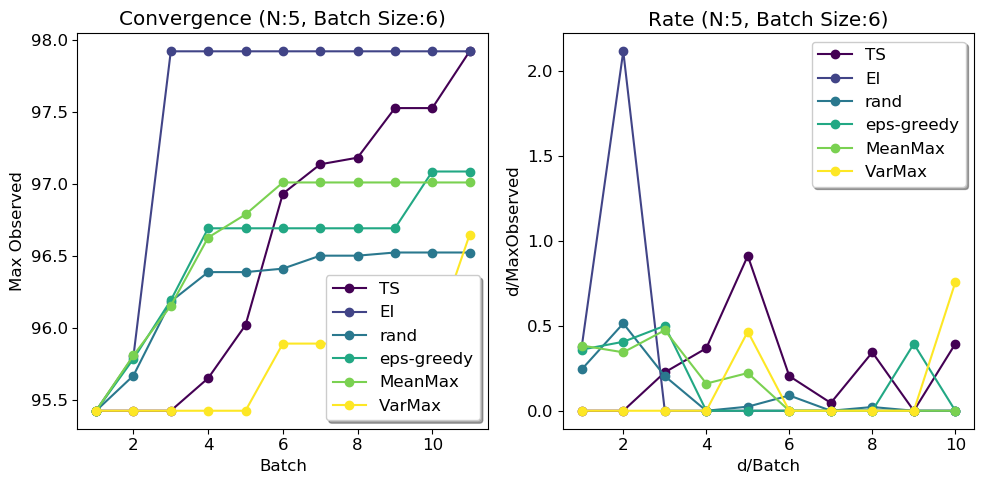

In [29]:
from edbo.plot_utils import compare_convergence

# Simulation
acq_funcs = ['TS', 'EI', 'rand', 'eps-greedy', 'MeanMax', 'VarMax']
acq_func_results = []

for acq_func in acq_funcs:
    # Run simulations
    print('Acquisition Function:', acq_func)
    results, mean, std = simulate(casp15,          # Data from reaction 
                              acq_func,            # Iterate over acq. funcs.
                              model=GP_Model,      # Gaussian process model
                              init_method='rand',  # Random initialization
                              batch_size=5,        # Choose 5 samples at a time
                              iterations=12,        # Run for 12 iterations
                              average_of=5,       # Run with 10 different random seeds
                              export_path='simulation_output_acq_funcs', # Don't save the results
                              plot=True)           # Plot the average results
    # Save results
    acq_func_results.append(mean)

# Compare average convergence for each acquisition function
print('Average performance for all acquisition functions:')
compare_convergence(acq_func_results, 6, acq_funcs)

Acquisition Function: TS
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


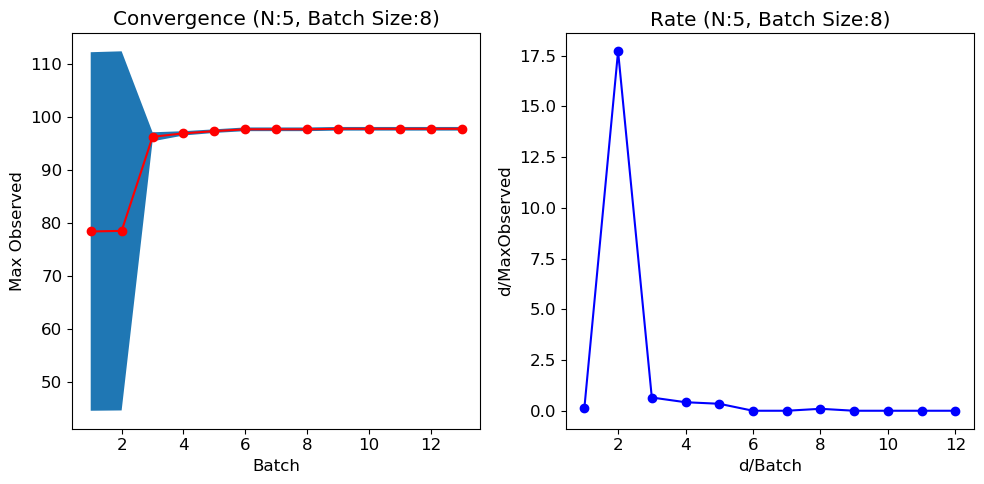

Acquisition Function: EI
Experiment 1/5...


C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users

Experiment 2/5...
Experiment 3/5...


C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(do

Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6


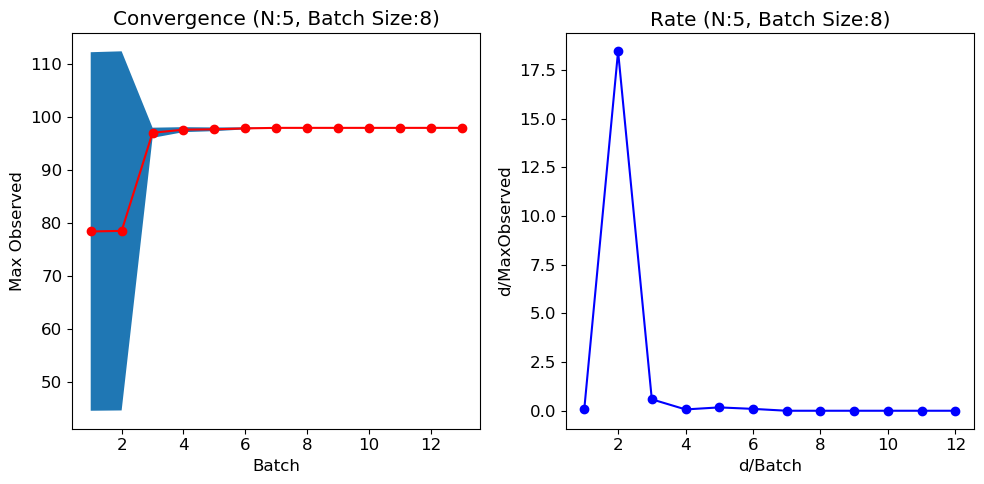

Acquisition Function: rand
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


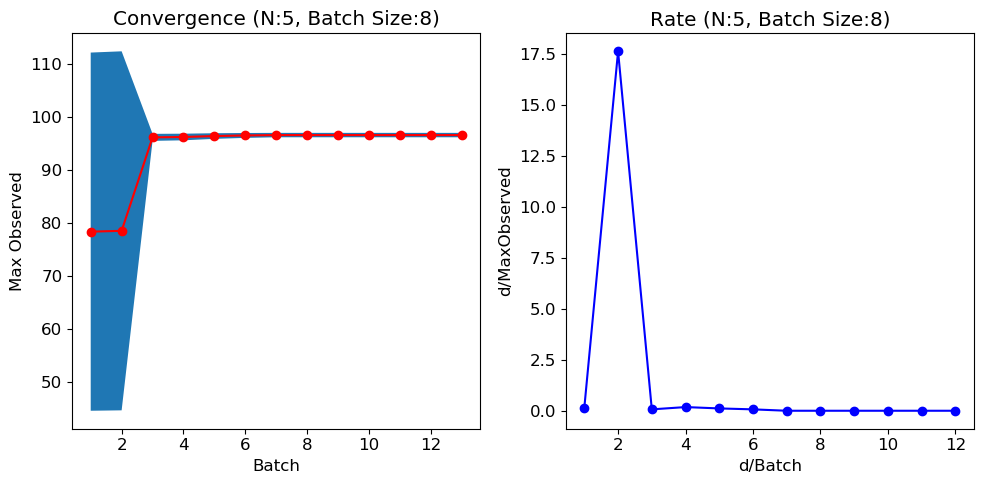

Acquisition Function: eps-greedy
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


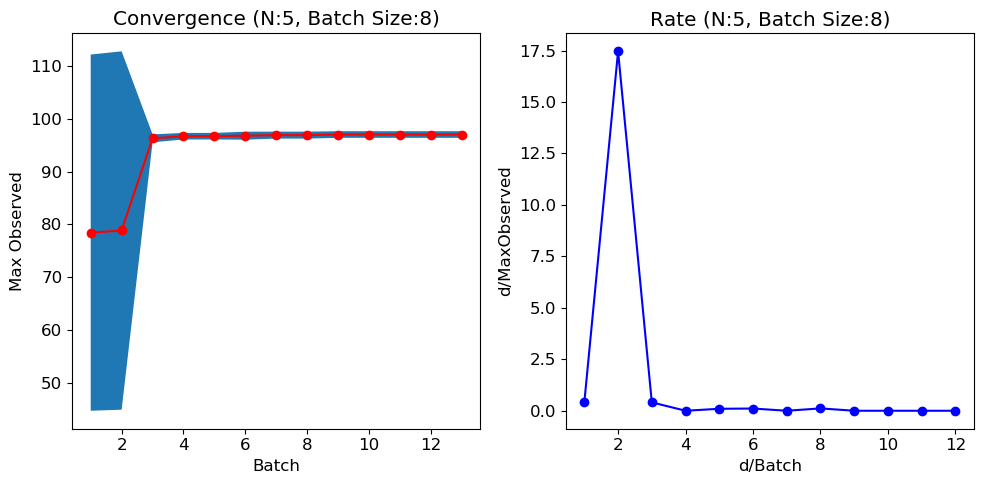

Acquisition Function: MeanMax
Experiment 1/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagona

Experiment 2/5...
Experiment 3/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarni

Experiment 4/5...
Experiment 5/5...


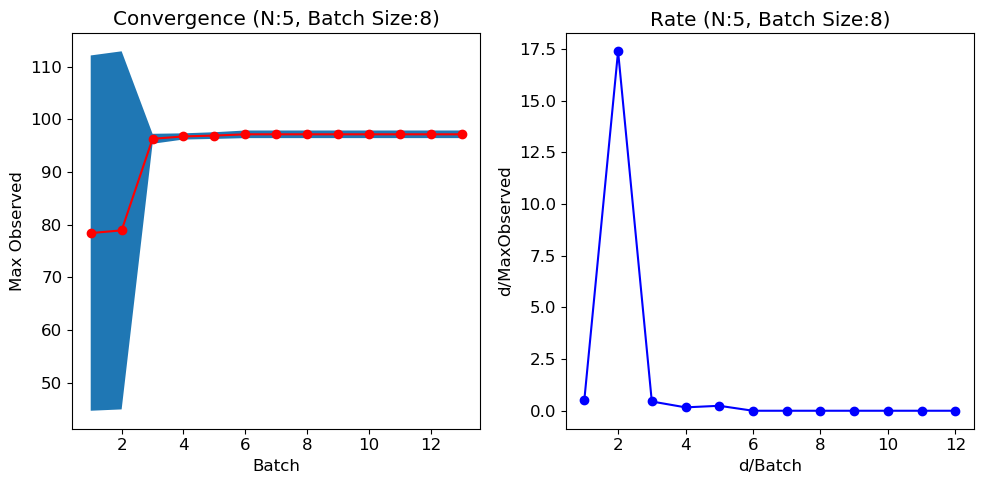

Acquisition Function: VarMax
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagona

Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\luc

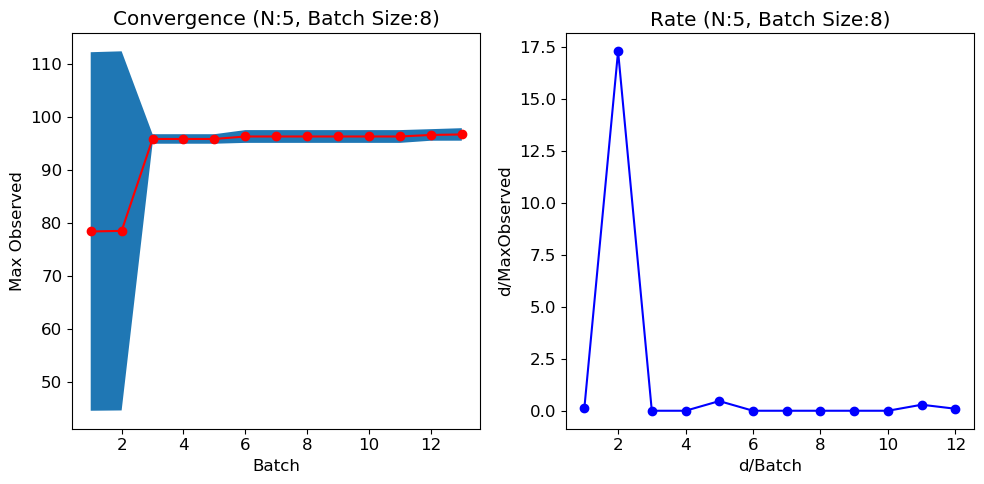

Average performance for all acquisition functions:


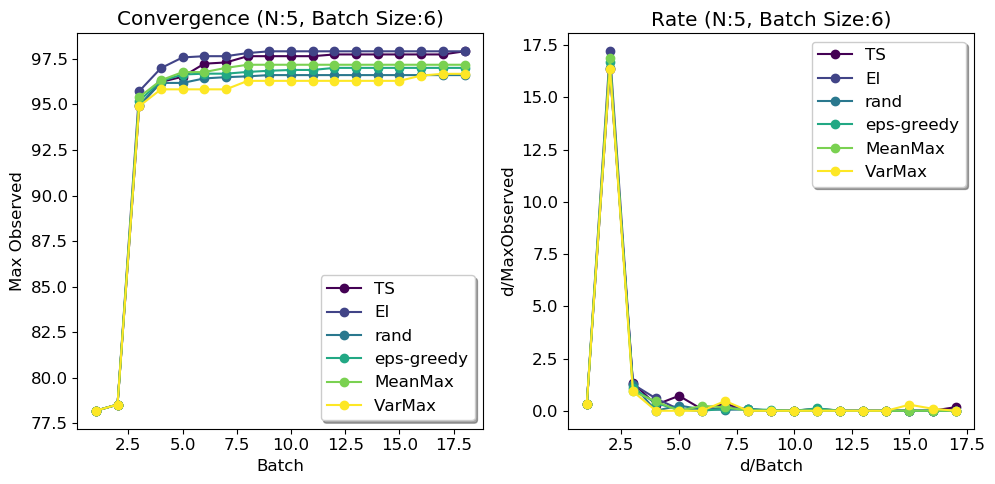

In [31]:
from edbo.plot_utils import compare_convergence

# Simulation
acq_funcs = ['TS', 'EI', 'rand', 'eps-greedy', 'MeanMax', 'VarMax']
acq_func_results = []

for acq_func in acq_funcs:
    # Run simulations
    print('Acquisition Function:', acq_func)
    results, mean, std = simulate(casp15,          # Data from reaction 
                              acq_func,            # Iterate over acq. funcs.
                              model=GP_Model,      # Gaussian process model
                              init_method='rand',  # Random initialization
                              batch_size=8,        # Choose 5 samples at a time
                              iterations=12,        # Run for 12 iterations
                              average_of=5,       # Run with 10 different random seeds
                              export_path='simulation_output_acq_funcs', # Don't save the results
                              plot=True)           # Plot the average results
    # Save results
    acq_func_results.append(results)

# Compare average convergence for each acquisition function
print('Average performance for all acquisition functions:')
compare_convergence(acq_func_results, 6, acq_funcs)

#### Ideas

- Visualise the surrogate model space (posterior) after certain numbers of iterations to show exploration/exploitation
- Visualise the separation of the data in space for a few features